In [1]:
# Library Imports and Module Setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from scipy import stats,signal
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Data Loading and CSV Aggregation

import os
import glob
import pandas as pd

# Base path for subfolders
base_path = "/kaggle/input/vertical-misalignment/vertical-misalignment"
subfolders = os.listdir(base_path)
print("Contents of Nested Directory:", subfolders)

# Gather CSV files from all subfolders
all_file_names = []
for subfolder in subfolders:
    folder_path = os.path.join(base_path, subfolder)
    csv_files = glob.glob(f"{folder_path}/*.csv")
    all_file_names.extend(csv_files)

print(f"Total CSV Files Found: {len(all_file_names)}")
print("List of Files:", all_file_names)

# Data reading function
def dataReader(path_names):
    data_n = pd.DataFrame()
    for file_path in path_names:
        try:
            print(f"Reading file: {file_path}")
            low_data = pd.read_csv(file_path, header=None)  # Assuming no headers
            if low_data.empty:
                print(f"Warning: File {file_path} is empty.")
            data_n = pd.concat([data_n, low_data], ignore_index=True)
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
    return data_n

# Load all data from CSV files
data_combined = dataReader(all_file_names)

# Display results
print("Combined Data Info:")
print(data_combined.info())
print("First 5 rows of Combined Data:")
print(data_combined.head())


Contents of Nested Directory: ['0.51mm', '0.63mm', '1.40mm', '1.90mm', '1.27mm', '1.78mm']
Total CSV Files Found: 301
List of Files: ['/kaggle/input/vertical-misalignment/vertical-misalignment/0.51mm/53.6576.csv', '/kaggle/input/vertical-misalignment/vertical-misalignment/0.51mm/16.9984.csv', '/kaggle/input/vertical-misalignment/vertical-misalignment/0.51mm/37.6832.csv', '/kaggle/input/vertical-misalignment/vertical-misalignment/0.51mm/56.7296.csv', '/kaggle/input/vertical-misalignment/vertical-misalignment/0.51mm/28.4672.csv', '/kaggle/input/vertical-misalignment/vertical-misalignment/0.51mm/16.1792.csv', '/kaggle/input/vertical-misalignment/vertical-misalignment/0.51mm/61.2352.csv', '/kaggle/input/vertical-misalignment/vertical-misalignment/0.51mm/36.0448.csv', '/kaggle/input/vertical-misalignment/vertical-misalignment/0.51mm/42.8032.csv', '/kaggle/input/vertical-misalignment/vertical-misalignment/0.51mm/34.2016.csv', '/kaggle/input/vertical-misalignment/vertical-misalignment/0.51mm/

In [3]:
data_combined.head(10)

,0,1,2,3,4,5,6,7
0,-0.86232,1.26110,0.265810,1.238900,-0.18802,-0.027365,-0.104900,-0.164470
1,-0.84612,1.29650,-0.017689,1.187900,-0.17431,-0.025594,-0.199640,0.079586
2,-0.89970,1.17710,0.364380,0.621810,-0.17991,-0.028559,-0.219850,-0.106550
3,-0.93687,1.43210,0.861810,-0.247380,-0.17692,-0.026980,-0.058111,0.002679
4,-0.84568,1.27970,0.697200,-0.964310,-0.18913,-0.029387,-0.133610,0.006402
5,-0.90302,1.39820,1.025300,-1.285900,-0.17712,-0.027943,0.003642,-0.116600
6,-0.85979,1.02950,0.051613,-1.209700,-0.19220,-0.030728,-0.029880,0.136660
7,-0.81454,1.09420,0.611510,-0.632540,-0.16966,-0.028334,-0.028333,-0.211250
8,-0.85984,0.62314,0.038206,-0.012246,-0.17757,-0.030311,-0.152630,0.224540
9,-0.83304,0.67735,0.627080,0.715410,-0.16930,-0.029156,-0.154910,-0.163910


In [4]:
# Column Descriptions:

# Column 1: Tachometer signal used to estimate the rotation frequency.

# Columns 2 to 4: Underhang bearing accelerometer measurements 
# in the axial, radial, and tangential directions.

# Columns 5 to 7: Overhang bearing accelerometer measurements 
# in the axial, radial, and tangential directions.

# Column 8: Microphone data.

features_list = ["Tachometer","UBA_axial","UBA_radial","UBA_tangential","OBA_axial","OBA_radial","OBA_tangential","Microphone"]

In [5]:
# Data Preprocessing and Down-Sampling

import pandas as pd
import numpy as np
import glob

# Function to read data from given paths
def dataReader(path_names):
    """
    Reads and concatenates CSV files into a single DataFrame.
    Parameters:
        path_names (list): List of file paths.
    Returns:
        DataFrame: Combined data from all files.
    """
    data_n = pd.DataFrame()
    for i in path_names:
        low_data = pd.read_csv(i, header=None)
        data_n = pd.concat([data_n, low_data], ignore_index=True)
    return data_n

# Optimized down-sampling function
def fastDownSampler(data, b):
    """
    Efficiently down-sample the data by averaging every 'b' rows.
    Parameters:
        data (DataFrame): The DataFrame to be down-sampled.
        b (int): The number of rows to group and average.
    Returns:
        DataFrame: A down-sampled DataFrame.
    """
    data_array = data.to_numpy()  # Convert DataFrame to NumPy array
    num_groups = len(data_array) // b  # Calculate the number of complete groups
    reshaped_data = data_array[:num_groups * b].reshape(num_groups, b, -1)  # Reshape for grouping
    downsampled_array = reshaped_data.mean(axis=1)  # Compute the mean for each group
    return pd.DataFrame(downsampled_array, columns=data.columns)  # Convert back to DataFrame

# Paths for data directories (adjust paths as necessary)
normal_file_names = glob.glob("./normal/*.csv")
vertical_misalignment_file_names_051mm = glob.glob("/kaggle/input/vertical-misalignment/vertical-misalignment/0.51mm/*.csv")
vertical_misalignment_file_names_063mm = glob.glob("/kaggle/input/vertical-misalignment/vertical-misalignment/0.63mm/*.csv")
vertical_misalignment_file_names_127mm = glob.glob("/kaggle/input/vertical-misalignment/vertical-misalignment/1.27mm/*.csv")
vertical_misalignment_file_names_140mm = glob.glob("/kaggle/input/vertical-misalignment/vertical-misalignment/1.40mm/*.csv")
vertical_misalignment_file_names_178mm = glob.glob("/kaggle/input/vertical-misalignment/vertical-misalignment/1.78mm/*.csv")
vertical_misalignment_file_names_190mm = glob.glob("/kaggle/input/vertical-misalignment/vertical-misalignment/1.90mm/*.csv")

# Reading data
data_normal = dataReader(normal_file_names)
data_vertical_misalignment_051mm = dataReader(vertical_misalignment_file_names_051mm)
data_vertical_misalignment_063mm = dataReader(vertical_misalignment_file_names_063mm)
data_vertical_misalignment_127mm = dataReader(vertical_misalignment_file_names_127mm)
data_vertical_misalignment_140mm = dataReader(vertical_misalignment_file_names_140mm)
data_vertical_misalignment_178mm = dataReader(vertical_misalignment_file_names_178mm)
data_vertical_misalignment_190mm = dataReader(vertical_misalignment_file_names_190mm)

# Down-sampling the data if it is not empty
sampling_rate = 100  # Adjust sampling rate as needed
if not data_normal.empty:
    data_normal = fastDownSampler(data_normal, b=sampling_rate)

if not data_vertical_misalignment_051mm.empty:
    data_vertical_misalignment_051mm = fastDownSampler(data_vertical_misalignment_051mm, b=sampling_rate)

if not data_vertical_misalignment_063mm.empty:
    data_vertical_misalignment_063mm = fastDownSampler(data_vertical_misalignment_063mm, b=sampling_rate)

if not data_vertical_misalignment_127mm.empty:
    data_vertical_misalignment_127mm = fastDownSampler(data_vertical_misalignment_127mm, b=sampling_rate)

if not data_vertical_misalignment_140mm.empty:
    data_vertical_misalignment_140mm = fastDownSampler(data_vertical_misalignment_140mm, b=sampling_rate)

if not data_vertical_misalignment_178mm.empty:
    data_vertical_misalignment_178mm = fastDownSampler(data_vertical_misalignment_178mm, b=sampling_rate)

if not data_vertical_misalignment_190mm.empty:
    data_vertical_misalignment_190mm = fastDownSampler(data_vertical_misalignment_190mm, b=sampling_rate)

# Combining all the data into one DataFrame
data_combined = pd.concat([
    data_normal, 
    data_vertical_misalignment_051mm,
    data_vertical_misalignment_063mm,
    data_vertical_misalignment_127mm,
    data_vertical_misalignment_140mm,
    data_vertical_misalignment_178mm,
    data_vertical_misalignment_190mm
], ignore_index=True)

# Print data_combined info to confirm
print("Combined Data Info:")
print(data_combined.info())
print("First 5 rows of the combined data:")
print(data_combined.head())


Combined Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752500 entries, 0 to 752499
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       752500 non-null  float64
 1   1       752500 non-null  float64
 2   2       752500 non-null  float64
 3   3       752500 non-null  float64
 4   4       752500 non-null  float64
 5   5       752500 non-null  float64
 6   6       752500 non-null  float64
 7   7       752500 non-null  float64
dtypes: float64(8)
memory usage: 45.9 MB
None
First 5 rows of the combined data:
          0         1         2         3         4         5         6  \
0 -0.799047  0.271861  0.008357 -0.071606 -0.080229 -0.015787 -0.478902   
1 -0.731127 -0.754449 -0.173588 -0.017898  0.342850  0.060131 -0.281925   
2 -0.729496 -0.282760 -0.031706 -0.112520  0.128216  0.039894  0.109272   
3 -0.578140  0.936058 -0.346348  0.025668 -0.079910 -0.003122 -0.069492   
4 -0.613504 -0.159313 -0.029005  0

In [6]:
data_vertical_misalignment_051mm.shape

(127500, 8)

In [7]:
# Feature Assignment for Misalignment Datasets

data_vertical_misalignment_051mm.columns = features_list
data_vertical_misalignment_063mm.columns = features_list
data_vertical_misalignment_127mm.columns = features_list
data_vertical_misalignment_140mm.columns = features_list
data_vertical_misalignment_178mm.columns = features_list
data_vertical_misalignment_190mm.columns = features_list


In [8]:
data_vertical_misalignment_051mm.head(10)

,Tachometer,UBA_axial,UBA_radial,UBA_tangential,OBA_axial,OBA_radial,OBA_tangential,Microphone
0,-0.799047,0.271861,0.008357,-0.071606,-0.080229,-0.015787,-0.478902,0.040704
1,-0.731127,-0.754449,-0.173588,-0.017898,0.342850,0.060131,-0.281925,0.081434
2,-0.729496,-0.282760,-0.031706,-0.112520,0.128216,0.039894,0.109272,0.002567
3,-0.578140,0.936058,-0.346348,0.025668,-0.079910,-0.003122,-0.069492,-0.003525
4,-0.613504,-0.159313,-0.029005,0.187303,0.299172,0.026656,-0.256507,0.010149
5,-0.722174,0.182270,0.092208,0.026194,-0.095564,-0.018738,0.280415,-0.009843
6,-0.719404,-0.166175,0.092239,-0.043105,0.200608,0.043042,0.412582,-0.016676
7,3.417777,0.693962,0.317045,0.213310,0.397071,0.044030,0.043715,-0.003251
8,2.190119,-0.607416,0.095653,-0.104183,0.237207,0.015988,0.487596,0.026514
9,-0.759311,0.294465,0.112970,-0.127289,0.013018,0.003363,0.160504,0.014405


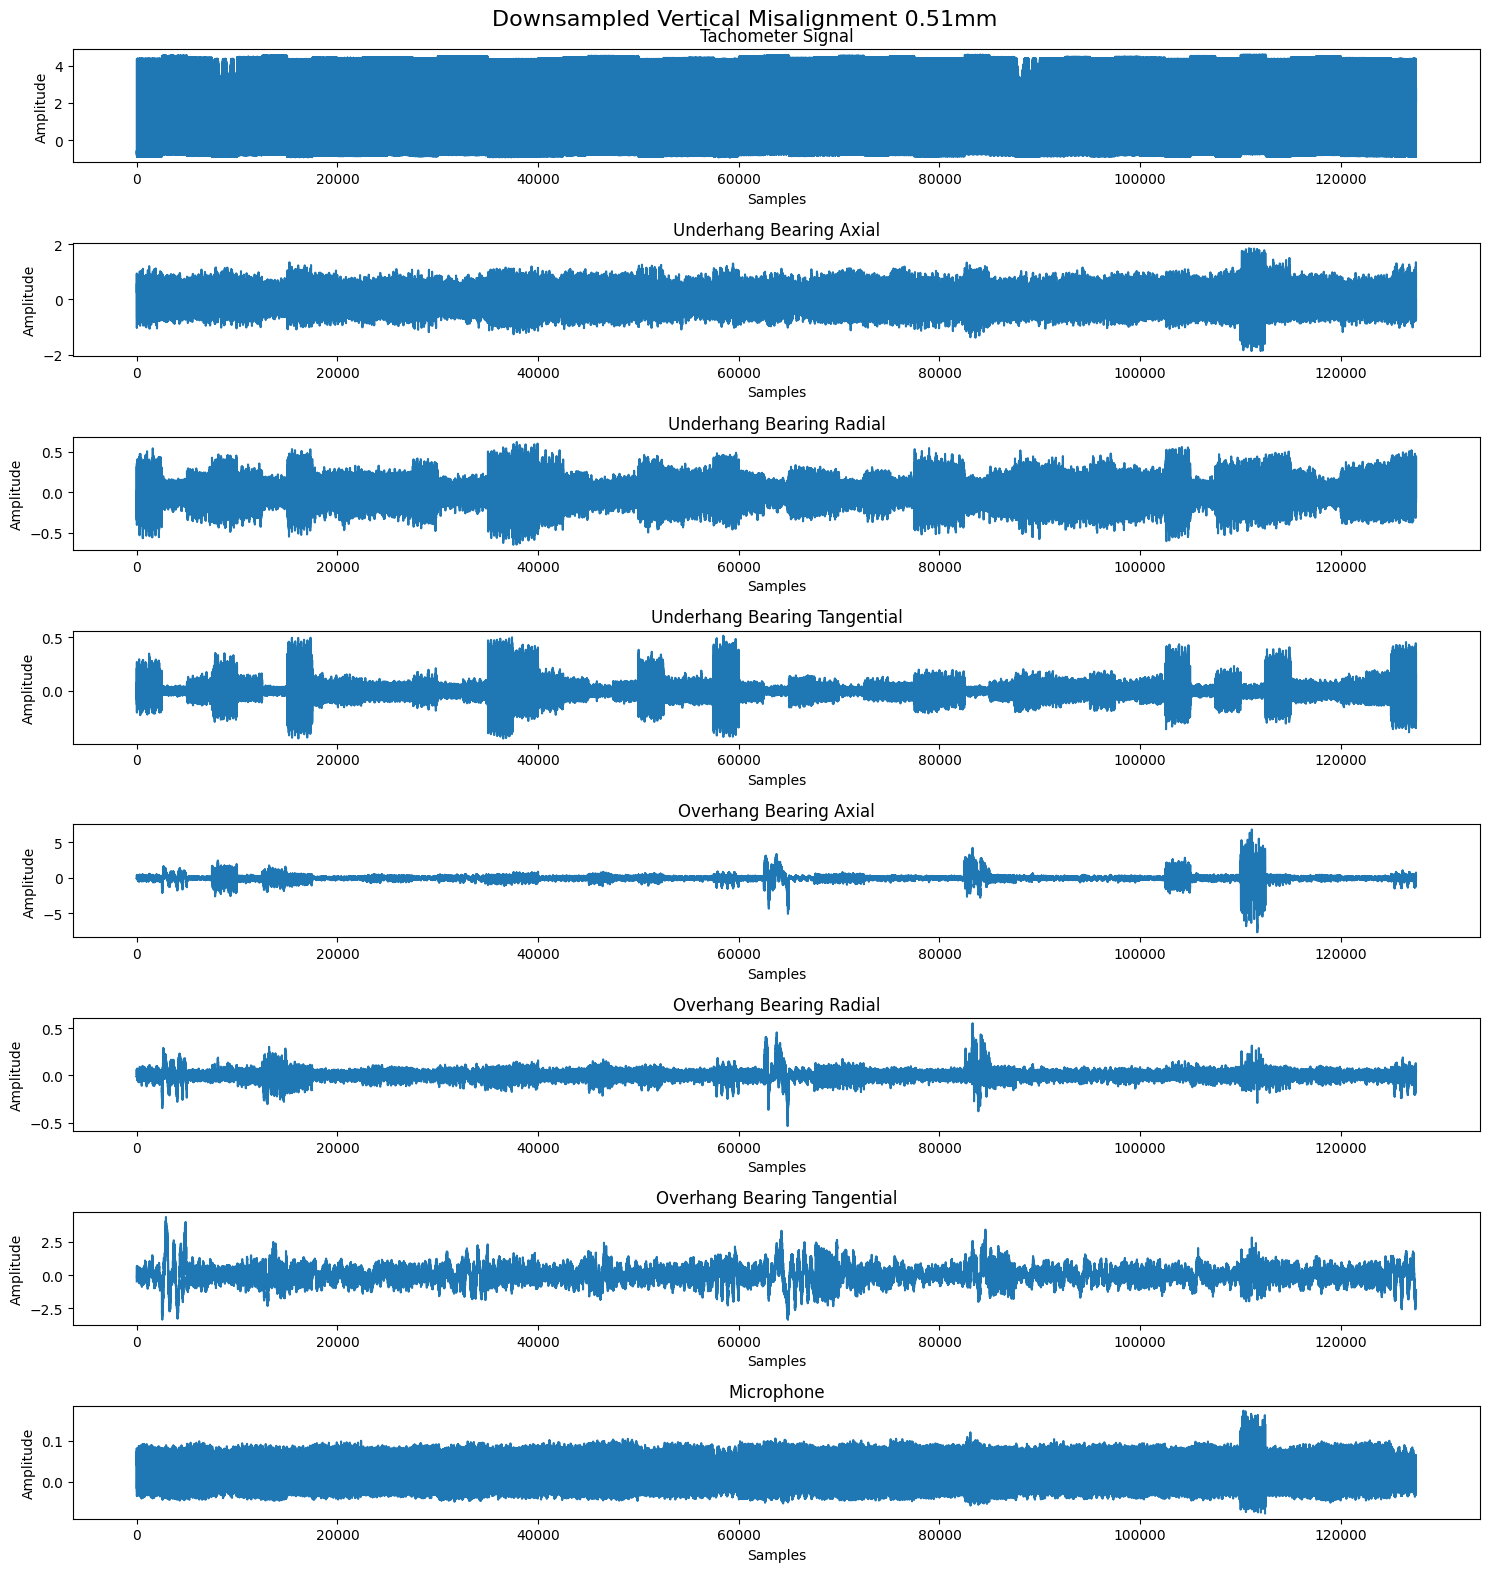

In [9]:
# Visualization of Downsampled Dataset Features


import matplotlib.pyplot as plt
import pandas as pd
import glob

# Function to read data from given paths
def dataReader(path_names):
    data_n = pd.DataFrame()
    for i in path_names:
        low_data = pd.read_csv(i, header=None)
        data_n = pd.concat([data_n, low_data], ignore_index=True)
    return data_n

# Optimized function to down-sample data
def downSampler(data, b=100):
    return data.groupby(data.index // b).mean()

# Function to plot all features of a dataset
def plot_data(data, title="All Features of Data"):
    """
    Plot all features in the DataFrame with descriptive column titles.
    Parameters:
        data (DataFrame): The data to plot, with meaningful column names.
        title (str): The overall title for the plots.
    """
    fig, axs = plt.subplots(len(data.columns), sharex=False, sharey=False, figsize=(15, len(data.columns) * 2))
    fig.suptitle(title, fontsize=16)
    
    for idx, col in enumerate(data.columns):
        axs[idx].plot(data[col])
        axs[idx].set_title(f'{col}')  # Use descriptive column names
        axs[idx].set_xlabel("Samples")
        axs[idx].set_ylabel("Amplitude")
    
    plt.tight_layout()
    plt.show()

# Paths for data directories
vertical_misalignment_file_names_051mm = glob.glob("/kaggle/input/vertical-misalignment/vertical-misalignment/0.51mm/*.csv")

# Reading and down-sampling the data
data_vertical_misalignment_051mm = dataReader(vertical_misalignment_file_names_051mm)
if not data_vertical_misalignment_051mm.empty:
    # Set descriptive column names for the dataset
    data_vertical_misalignment_051mm.columns = [
        "Tachometer Signal",
        "Underhang Bearing Axial",
        "Underhang Bearing Radial",
        "Underhang Bearing Tangential",
        "Overhang Bearing Axial",
        "Overhang Bearing Radial",
        "Overhang Bearing Tangential",
        "Microphone"
    ]
    
    # Down-sample the data
    data_vertical_misalignment_051mm = downSampler(data_vertical_misalignment_051mm, b=100)

# Plotting the downsampled data
if not data_vertical_misalignment_051mm.empty:
    plot_data(data_vertical_misalignment_051mm, title="Downsampled Vertical Misalignment 0.51mm")


In [12]:
# Signal Analysis Using Welch's Method for PSD//not used

import pandas as pd
import numpy as np
import glob
from scipy import signal

# Function to read data
def dataReader(path_names):
    """
    Reads all CSV files from the given paths and combines them into a single DataFrame.
    """
    data = pd.DataFrame()
    for path in path_names:
        df = pd.read_csv(path, header=None, dtype='float32')  # Use float32 to save memory
        data = pd.concat([data, df], ignore_index=True)
    return data

# Function to downsample data
def downSampler(data, factor=100):
    """
    Downsamples the data by averaging every 'factor' rows.
    """
    return data.groupby(data.index // factor).mean()

# Function to compute the Welch method for PSD
def compute_psd(data, fs=1.0, nperseg=256):
    """
    Computes the Power Spectral Density (PSD) using Welch's method.
    """
    psd_result = pd.DataFrame()
    for start in range(0, len(data), nperseg):
        segment = data.iloc[start:start + nperseg]
        f, Pxx = signal.welch(segment, fs=fs, nperseg=nperseg)
        psd_result = pd.concat([psd_result, pd.DataFrame(Pxx)], ignore_index=True)
    return psd_result

# Paths for data directories
normal_file_names = glob.glob("./normal/*.csv")
vertical_misalignment_file_names_051mm = glob.glob("/kaggle/input/vertical-misalignment/vertical-misalignment/0.51mm/*.csv")
vertical_misalignment_file_names_063mm = glob.glob("/kaggle/input/vertical-misalignment/vertical-misalignment/0.63mm/*.csv")
vertical_misalignment_file_names_127mm = glob.glob("/kaggle/input/vertical-misalignment/vertical-misalignment/1.27mm/*.csv")
vertical_misalignment_file_names_140mm = glob.glob("/kaggle/input/vertical-misalignment/vertical-misalignment/1.40mm/*.csv")
vertical_misalignment_file_names_178mm = glob.glob("/kaggle/input/vertical-misalignment/vertical-misalignment/1.78mm/*.csv")
vertical_misalignment_file_names_190mm = glob.glob("/kaggle/input/vertical-misalignment/vertical-misalignment/1.90mm/*.csv")

# Read and downsample data
data_normal = downSampler(dataReader(normal_file_names), factor=100)
data_051mm = downSampler(dataReader(vertical_misalignment_file_names_051mm), factor=100)
data_063mm = downSampler(dataReader(vertical_misalignment_file_names_063mm), factor=100)
data_127mm = downSampler(dataReader(vertical_misalignment_file_names_127mm), factor=100)
data_140mm = downSampler(dataReader(vertical_misalignment_file_names_140mm), factor=100)
data_178mm = downSampler(dataReader(vertical_misalignment_file_names_178mm), factor=100)
data_190mm = downSampler(dataReader(vertical_misalignment_file_names_190mm), factor=100)

# Apply PSD computation
if not data_normal.empty:
    data_normal_psd = compute_psd(data_normal, fs=1.0, nperseg=256)
else:
    data_normal_psd = pd.DataFrame()

if not data_051mm.empty:
    data_051mm_psd = compute_psd(data_051mm, fs=1.0, nperseg=256)
else:
    data_051mm_psd = pd.DataFrame()

if not data_063mm.empty:
    data_063mm_psd = compute_psd(data_063mm, fs=1.0, nperseg=256)
else:
    data_063mm_psd = pd.DataFrame()

if not data_127mm.empty:
    data_127mm_psd = compute_psd(data_127mm, fs=1.0, nperseg=256)
else:
    data_127mm_psd = pd.DataFrame()

if not data_140mm.empty:
    data_140mm_psd = compute_psd(data_140mm, fs=1.0, nperseg=256)
else:
    data_140mm_psd = pd.DataFrame()

if not data_178mm.empty:
    data_178mm_psd = compute_psd(data_178mm, fs=1.0, nperseg=256)
else:
    data_178mm_psd = pd.DataFrame()

if not data_190mm.empty:
    data_190mm_psd = compute_psd(data_190mm, fs=1.0, nperseg=256)
else:
    data_190mm_psd = pd.DataFrame()

# Combine results if necessary
data_combined_psd = pd.concat([
    data_normal_psd,
    data_051mm_psd,
    data_063mm_psd,
    data_127mm_psd,
    data_140mm_psd,
    data_178mm_psd,
    data_190mm_psd
], ignore_index=True)

# Print result info
print("PSD Data Info:")
print(data_combined_psd.info())
print("First 5 rows of the PSD data:")
print(data_combined_psd.head())


/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 8, using nperseg = 8
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 8, using nperseg = 8
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 8, using nperseg = 8
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 8, using nperseg = 8
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg =

PSD Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752500 entries, 0 to 752499
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       752500 non-null  float32
 1   1       752500 non-null  float32
 2   2       752500 non-null  float32
 3   3       752500 non-null  float32
 4   4       752500 non-null  float32
dtypes: float32(5)
memory usage: 14.4 MB
None
First 5 rows of the PSD data:
          0         1         2         3         4
0  0.015842  0.045408  0.020454  0.042818  0.027395
1  0.207963  0.438029  0.219138  0.064411  0.010515
2  0.084082  0.098300  0.010531  0.015377  0.024304
3  0.001758  0.012198  0.019441  0.042713  0.065606
4  0.113966  0.247224  0.147683  0.016718  0.000006


In [13]:
data_combined_psd.head(10)

,0,1,2,3,4
0,0.015842,0.045408,0.020454,0.042818,0.027395
1,0.207963,0.438029,0.219138,0.064411,0.010515
2,0.084082,0.098300,0.010531,0.015377,0.024304
3,0.001758,0.012198,0.019441,0.042713,0.065606
4,0.113966,0.247224,0.147683,0.016718,0.000006
5,0.021671,0.002689,0.053039,0.017781,0.001166
6,0.091746,0.082691,0.003567,0.027741,0.076752
7,0.922491,0.491215,0.032501,0.066376,0.021956
8,0.214539,0.152065,0.002037,0.037580,0.158324
9,0.018119,0.003930,0.025715,0.010022,0.014742


In [14]:
data_combined_psd.shape

(752500, 5)

In [10]:
# FFT-based Autocorrelation Computation(column wise)

import pandas as pd
import numpy as np
import glob
from scipy import signal

# Function to read data
def dataReader(path_names):
    """
    Reads all CSV files from the given paths and combines them into a single DataFrame.
    """
    data = pd.DataFrame()
    for path in path_names:
        df = pd.read_csv(path, header=None, dtype='float32')  # Use float32 to save memory
        data = pd.concat([data, df], ignore_index=True)
    return data

# Function to downsample data
def downSampler(data, factor=100):
    """
    Downsamples the data by averaging every 'factor' rows.
    """
    return data.groupby(data.index // factor).mean()

# Function to compute column-wise FFT-based autocorrelation
def FFT_columnwise(data):
    """
    Computes FFT-based autocorrelation column-wise for the entire DataFrame.
    """
    autocorr_result = pd.DataFrame()
    for col in data.columns:
        col_data = data[col]
        autocorr = signal.fftconvolve(col_data, col_data[::-1], mode='full')
        autocorr_result[col] = autocorr[len(autocorr)//2:]  # Take only the second half
    return autocorr_result

# Paths for data directories
normal_file_names = glob.glob("./normal/*.csv")
vertical_misalignment_file_names_051mm = glob.glob("/kaggle/input/vertical-misalignment/vertical-misalignment/0.51mm/*.csv")
vertical_misalignment_file_names_063mm = glob.glob("/kaggle/input/vertical-misalignment/vertical-misalignment/0.63mm/*.csv")
vertical_misalignment_file_names_127mm = glob.glob("/kaggle/input/vertical-misalignment/vertical-misalignment/1.27mm/*.csv")
vertical_misalignment_file_names_140mm = glob.glob("/kaggle/input/vertical-misalignment/vertical-misalignment/1.40mm/*.csv")
vertical_misalignment_file_names_178mm = glob.glob("/kaggle/input/vertical-misalignment/vertical-misalignment/1.78mm/*.csv")
vertical_misalignment_file_names_190mm = glob.glob("/kaggle/input/vertical-misalignment/vertical-misalignment/1.90mm/*.csv")

# Read and downsample data
data_normal = downSampler(dataReader(normal_file_names), factor=100)
data_051mm = downSampler(dataReader(vertical_misalignment_file_names_051mm), factor=100)
data_063mm = downSampler(dataReader(vertical_misalignment_file_names_063mm), factor=100)
data_127mm = downSampler(dataReader(vertical_misalignment_file_names_127mm), factor=100)
data_140mm = downSampler(dataReader(vertical_misalignment_file_names_140mm), factor=100)
data_178mm = downSampler(dataReader(vertical_misalignment_file_names_178mm), factor=100)
data_190mm = downSampler(dataReader(vertical_misalignment_file_names_190mm), factor=100)

# Apply FFT column-wise
data_normal_autocorr = FFT_columnwise(data_normal) if not data_normal.empty else pd.DataFrame()
data_051mm_autocorr = FFT_columnwise(data_051mm) if not data_051mm.empty else pd.DataFrame()
data_063mm_autocorr = FFT_columnwise(data_063mm) if not data_063mm.empty else pd.DataFrame()
data_127mm_autocorr = FFT_columnwise(data_127mm) if not data_127mm.empty else pd.DataFrame()
data_140mm_autocorr = FFT_columnwise(data_140mm) if not data_140mm.empty else pd.DataFrame()
data_178mm_autocorr = FFT_columnwise(data_178mm) if not data_178mm.empty else pd.DataFrame()
data_190mm_autocorr = FFT_columnwise(data_190mm) if not data_190mm.empty else pd.DataFrame()

# Combine results if necessary
data_combined_autocorr = pd.concat([
    data_normal_autocorr,
    data_051mm_autocorr,
    data_063mm_autocorr,
    data_127mm_autocorr,
    data_140mm_autocorr,
    data_178mm_autocorr,
    data_190mm_autocorr
], axis=0, ignore_index=True)

# Print result info
print("Autocorrelation Data Info:")
print(data_combined_autocorr.info())
print("First 5 rows of the autocorrelation data:")
print(data_combined_autocorr.head())


Autocorrelation Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752500 entries, 0 to 752499
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       752500 non-null  float32
 1   1       752500 non-null  float32
 2   2       752500 non-null  float32
 3   3       752500 non-null  float32
 4   4       752500 non-null  float32
 5   5       752500 non-null  float32
 6   6       752500 non-null  float32
 7   7       752500 non-null  float32
dtypes: float32(8)
memory usage: 23.0 MB
None
First 5 rows of the autocorrelation data:
               0             1            2           3             4  \
0  297017.875000  16637.232422  2815.994141  924.235291  37950.425781   
1  141633.125000    864.322632   895.302429 -317.620087  31338.945312   
2   -4694.428223   1428.976807   711.745178    2.168545  30828.812500   
3  -45754.003906  -1224.381836  -265.169586  307.570831  33114.179688   
4  -56238.570312   4084.126221

In [11]:
data_combined_autocorr.head(20)

,0,1,2,3,4,5,6,7
0,297017.875000,16637.232422,2815.994141,924.235291,37950.425781,336.676910,53271.851562,124.441566
1,141633.125000,864.322632,895.302429,-317.620087,31338.945312,259.648468,50638.937500,61.645580
2,-4694.428223,1428.976807,711.745178,2.168545,30828.812500,243.607452,48638.535156,28.173618
3,-45754.003906,-1224.381836,-265.169586,307.570831,33114.179688,241.579514,47664.871094,20.981615
4,-56238.570312,4084.126221,-972.770325,-349.289642,29041.845703,219.421371,46158.097656,18.684427
5,-57571.906250,-26.864798,-1327.847168,-149.679855,27581.498047,211.771378,45056.578125,1.761137
6,-57175.226562,-2122.223633,-888.938782,205.457474,30237.615234,216.109604,44727.066406,-3.350083
7,-53977.457031,-2421.545898,-679.958862,-423.916962,26183.244141,190.355072,44146.808594,0.859571
8,-21161.121094,2619.653076,145.831345,115.532181,24692.070312,195.072388,44353.183594,19.086414
9,12608.594727,3094.113281,688.032532,286.128510,28228.460938,194.241043,44844.152344,28.864592


In [12]:
data_combined_autocorr.shape

(752500, 8)

In [13]:
# Label Creation and Encoding for Multi-Class Classification

from sklearn.preprocessing import LabelEncoder

# Create label DataFrames for each dataset
y_1 = pd.DataFrame(np.ones(len(data_normal), dtype=int))  # Label: 1
y_2 = pd.DataFrame(np.full(len(data_051mm), 2))           # Label: 2
y_3 = pd.DataFrame(np.full(len(data_063mm), 3))           # Label: 3
y_4 = pd.DataFrame(np.full(len(data_127mm), 4))           # Label: 4
y_5 = pd.DataFrame(np.full(len(data_140mm), 5))           # Label: 5
y_6 = pd.DataFrame(np.full(len(data_178mm), 6))           # Label: 6
y_7 = pd.DataFrame(np.full(len(data_190mm), 7))           # Label: 7

# Combine labels into a single DataFrame
y = pd.concat([y_1, y_2, y_3, y_4, y_5, y_6, y_7], ignore_index=True)

# Flatten the labels and encode them
y_flat = y.values.ravel()
y_encoded = LabelEncoder().fit_transform(y_flat)

# Convert encoded labels back to DataFrame
y_encoded_df = pd.DataFrame(y_encoded, columns=["Encoded Labels"])

# Sample 10 rows for verification
print("Sample encoded labels:")
print(y_encoded_df.sample(10))

# Train-test split can now use y_encoded_df as the target labels


Sample encoded labels:
        Encoded Labels
391724               3
256261               2
49809                0
391214               3
449842               3
451642               3
371439               2
267857               2
16129                0
589724               4


In [45]:
# Binary Label Conversion and Sampling for Classification

from sklearn.utils import resample
import pandas as pd
import numpy as np

# Create label DataFrames for each dataset
y_1 = pd.DataFrame(np.ones(len(data_normal), dtype=int))  # Label: 1
y_2 = pd.DataFrame(np.full(len(data_051mm), 2))           # Label: 2
y_3 = pd.DataFrame(np.full(len(data_063mm), 3))           # Label: 3
y_4 = pd.DataFrame(np.full(len(data_127mm), 4))           # Label: 4
y_5 = pd.DataFrame(np.full(len(data_140mm), 5))           # Label: 5
y_6 = pd.DataFrame(np.full(len(data_178mm), 6))           # Label: 6
y_7 = pd.DataFrame(np.full(len(data_190mm), 7))           # Label: 7

# Combine labels into a single DataFrame
y = pd.concat([y_1, y_2, y_3, y_4, y_5, y_6, y_7], ignore_index=True)

# Flatten the labels and encode them
y_flat = y.values.ravel()
y_encoded = LabelEncoder().fit_transform(y_flat)

# Convert encoded labels back to DataFrame
y_encoded_df = pd.DataFrame(y_encoded, columns=["Encoded Labels"])

# Convert to binary classification
# Define labels 1, 2 as class 0 (normal) and the rest as class 1 (abnormal)
y_binary = np.where(y_encoded_df["Encoded Labels"].isin([0, 1]), 0, 1)
y_binary_df = pd.DataFrame(y_binary, columns=["Binary Labels"])

# Separate the majority and minority classes
majority_class = y_binary_df[y_binary_df["Binary Labels"] == 1]
minority_class = y_binary_df[y_binary_df["Binary Labels"] == 0]

# Balance the classes using resampling
n_minority = len(minority_class)
majority_class_balanced = resample(majority_class,
                                   replace=False,     # Downsample without replacement
                                   n_samples=n_minority,  # Match the minority class size
                                   random_state=42)

# Combine the balanced classes
balanced_df = pd.concat([minority_class, majority_class_balanced])

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Print the label distribution after balancing
print("Binary label distribution after balancing:")
print(balanced_df["Binary Labels"].value_counts())

# Check for data availability before sampling
n_samples = 10
if len(balanced_df) >= n_samples:
    sampled_data = balanced_df.sample(n_samples, random_state=42)
    print("Sampled binary labels from balanced dataset:")
    print(sampled_data)
else:
    print(f"Not enough data to sample {n_samples} rows. Available rows: {len(balanced_df)}")




Binary label distribution after balancing:
Binary Labels
0    252500
1    252500
Name: count, dtype: int64
Sampled binary labels from balanced dataset:
        Binary Labels
23281               1
67202               0
357476              0
142682              0
461354              0
380697              0
140151              0
374621              1
107257              1
128263              1


In [16]:
# x_train, x_test, y_train, y_test = train_test_split(data_combined_autocorr,y_encoded, test_size=0.3, shuffle=True)

Model: Random Forest
Accuracy: 0.71
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81     37976
           1       0.85      0.82      0.83     37591
           2       0.62      0.62      0.62     37639
           3       0.66      0.60      0.63     37736
           4       0.63      0.69      0.66     37410
           5       0.69      0.76      0.73     37398

    accuracy                           0.71    225750
   macro avg       0.72      0.71      0.71    225750
weighted avg       0.72      0.71      0.71    225750



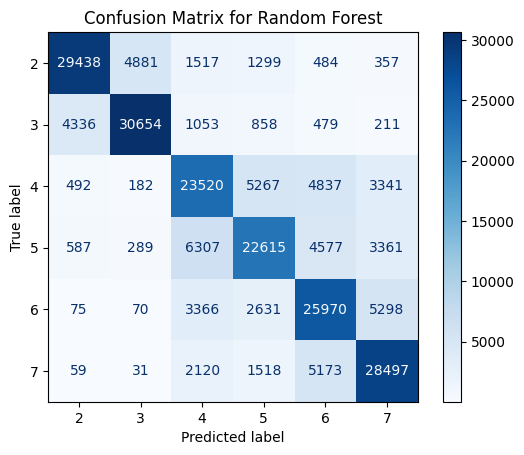

Model: Decision Tree
Accuracy: 0.61
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.73      0.72     37976
           1       0.76      0.76      0.76     37591
           2       0.50      0.49      0.50     37639
           3       0.51      0.51      0.51     37736
           4       0.54      0.54      0.54     37410
           5       0.62      0.63      0.62     37398

    accuracy                           0.61    225750
   macro avg       0.61      0.61      0.61    225750
weighted avg       0.61      0.61      0.61    225750



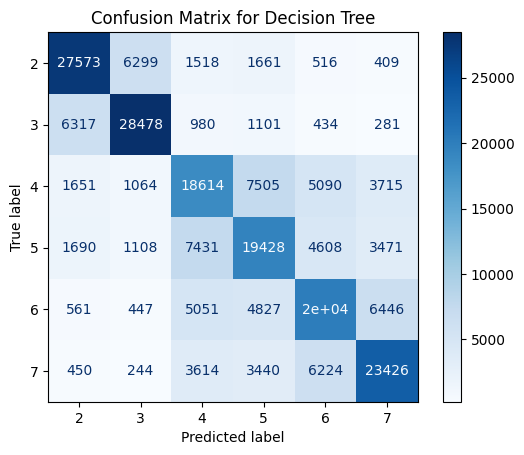

Model: K-Nearest Neighbors
Accuracy: 0.40
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.47      0.47     37976
           1       0.57      0.53      0.55     37591
           2       0.31      0.38      0.34     37639
           3       0.30      0.27      0.29     37736
           4       0.32      0.34      0.33     37410
           5       0.44      0.40      0.42     37398

    accuracy                           0.40    225750
   macro avg       0.40      0.40      0.40    225750
weighted avg       0.40      0.40      0.40    225750



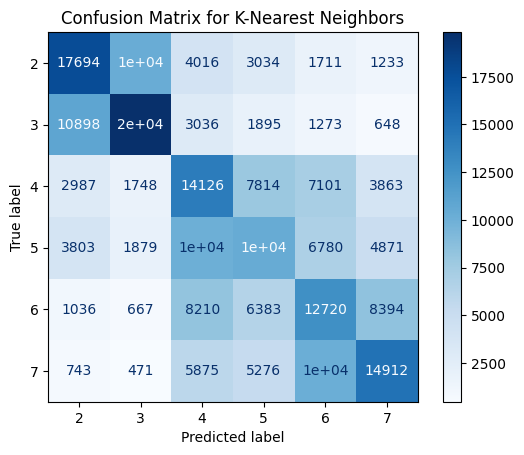

In [17]:
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
}

def train_and_evaluate_models(x_train, y_train, x_test, y_test):
    for model_name, model in classifiers.items():
        # Fit the model
        model.fit(x_train, y_train)
        
        # Make predictions
        y_pred = model.predict(x_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        # Generate confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Display results
        print(f"Model: {model_name}")
        print(f"Accuracy: {accuracy:.2f}")
        report = classification_report(y_test, y_pred)
        print("Classification Report:")
        print(report)
        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {model_name}')
        plt.show()

# Run the function to train and evaluate all models
train_and_evaluate_models(x_train, y_train, x_test, y_test)

In [46]:
x_train, x_test, y_train, y_test = train_test_split(data_combined_autocorr,y_binary, test_size=0.2, shuffle=True)

Training and Evaluating: Random Forest
Cross-Validation Accuracy: 0.96 ± 0.00
Test Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94     50627
           1       0.96      0.99      0.97     99873

    accuracy                           0.96    150500
   macro avg       0.97      0.95      0.96    150500
weighted avg       0.96      0.96      0.96    150500



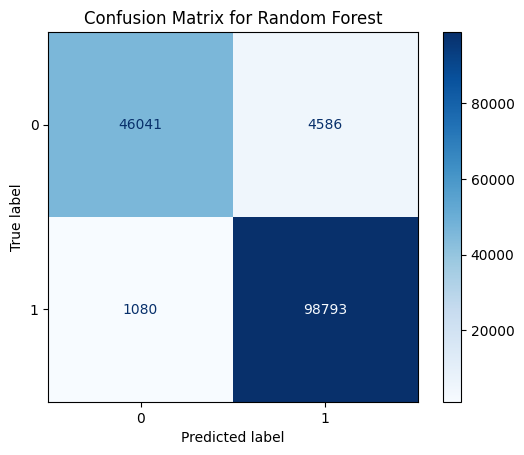

Training and Evaluating: Decision Tree
Cross-Validation Accuracy: 0.94 ± 0.00
Test Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91     50627
           1       0.95      0.95      0.95     99873

    accuracy                           0.94    150500
   macro avg       0.93      0.93      0.93    150500
weighted avg       0.94      0.94      0.94    150500



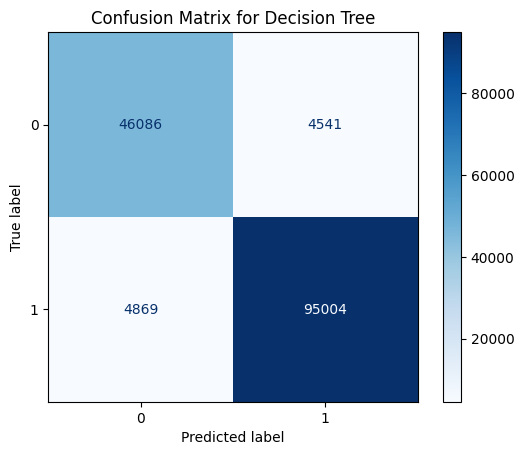

Training and Evaluating: K-Nearest Neighbors
Cross-Validation Accuracy: 0.87 ± 0.00
Test Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.70      0.78     50627
           1       0.86      0.96      0.91     99873

    accuracy                           0.87    150500
   macro avg       0.88      0.83      0.84    150500
weighted avg       0.87      0.87      0.86    150500



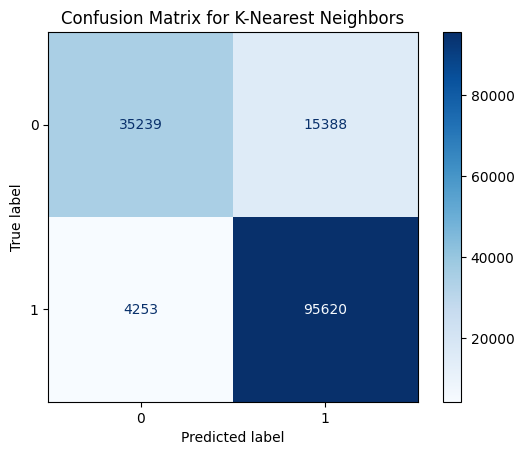

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
}

# Function for cross-validation and evaluation
def train_evaluate_cv(x_train, y_train, x_test, y_test):
    for model_name, model in classifiers.items():
        print(f"Training and Evaluating: {model_name}")
        
        # Create a pipeline with scaling (if needed)
        pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Scaler (if applicable, ignored for tree models)
            ('model', model)
        ])
        
        # Perform 5-fold cross-validation
        cv_scores = cross_val_score(pipeline, x_train, y_train, cv=5, scoring='accuracy')
        print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")
        
        # Fit on full training data
        pipeline.fit(x_train, y_train)
        
        # Evaluate on test data
        y_pred = pipeline.predict(x_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Test Accuracy: {accuracy:.2f}")
        
        # Generate and display classification report
        report = classification_report(y_test, y_pred)
        print("Classification Report:")
        print(report)
        
        # Generate and plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {model_name}')
        plt.show()

# Call function to train and evaluate models
train_evaluate_cv(x_train, y_train, x_test, y_test)


In [48]:
data_combined_autocorr.head(10)

,0,1,2,3,4,5,6,7
0,297017.875000,16637.232422,2815.994141,924.235291,37950.425781,336.676910,53271.851562,124.441566
1,141633.125000,864.322632,895.302429,-317.620087,31338.945312,259.648468,50638.937500,61.645580
2,-4694.428223,1428.976807,711.745178,2.168545,30828.812500,243.607452,48638.535156,28.173618
3,-45754.003906,-1224.381836,-265.169586,307.570831,33114.179688,241.579514,47664.871094,20.981615
4,-56238.570312,4084.126221,-972.770325,-349.289642,29041.845703,219.421371,46158.097656,18.684427
5,-57571.906250,-26.864798,-1327.847168,-149.679855,27581.498047,211.771378,45056.578125,1.761137
6,-57175.226562,-2122.223633,-888.938782,205.457474,30237.615234,216.109604,44727.066406,-3.350083
7,-53977.457031,-2421.545898,-679.958862,-423.916962,26183.244141,190.355072,44146.808594,0.859571
8,-21161.121094,2619.653076,145.831345,115.532181,24692.070312,195.072388,44353.183594,19.086414
9,12608.594727,3094.113281,688.032532,286.128510,28228.460938,194.241043,44844.152344,28.864592


In [54]:
import os

# Define the path
output_path = 'D:/DOWNLOADS new'

# Create the directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Now you can save the DataFrame
data_combined_autocorr.to_csv(f'{output_path}/combined.csv', index=False)


In [55]:
import pandas as pd

# Load the CSV file
file_path = '/kaggle/working/D:\DOWNLOADS new\combined.csv'
data = pd.read_csv(file_path)

# Slice the DataFrame to the first 1000 rows
sliced_data = data.iloc[:1000]

# Save the new DataFrame to a CSV file
sliced_file_path = 'sliced_file.csv'
sliced_data.to_csv(sliced_file_path, index=False)

print("Sliced file saved as:", sliced_file_path)


Sliced file saved as: sliced_file.csv
